# Purpose:
- Try identifying the source of clustering index variation from neuronal activities
    - Number of fit neurons, touch neurons, tuned neurons, explained variance, etc.
    - (behavior features do not seem to affect- cf., 240421_clustering_index_from_subsampled.ipynb)


In [1]:
import numpy as np
import pandas as pd
from importlib import reload
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
import matplotlib
matplotlib.style.use('default')
import xarray as xr
from utils import lda_angle_discrim as lad
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from scipy.spatial.distance import pdist, squareform
from scipy.optimize import linear_sum_assignment
import utils.lda_angle_discrim as lda_angle
import utils.logistic_regression_angle as logireg_angle
import utils.clustering_index as ci
import pickle


# base_dir = Path(r'E:\TPM\JK\h5')
base_dir = Path(r'C:\JK')

results_dir = base_dir / 'results'
# wf_dir = results_dir / 'touch_whisker_features'
# b_dir = Path(r'E:\TPM\JK\SoloData')

expert_mice_df = pd.read_csv(base_dir / 'expert_mice.csv', index_col=0)
use_mice_df = expert_mice_df.loc[expert_mice_df['depth_matched'].astype(bool) & 
                                 ~expert_mice_df['processing_error'].astype(bool) &
                                 ((expert_mice_df.session_type == 'training') |
                                  (expert_mice_df.session_type.str.contains('test')))]
use_volume_df = use_mice_df.query('plane in [1, 5]')
use_volume_df.loc[:, 'volume'] = use_volume_df['plane'].apply(lambda x: 1 if x==1 else 2)
training_volume_df = use_volume_df.query('session_type == "training"')
remove_ind = training_volume_df.query('mouse==27 and session=="15"')
training_volume_df = training_volume_df.drop(remove_ind.index)
remove_ind = training_volume_df.query('mouse==36 and session=="9"')
training_volume_df = training_volume_df.drop(remove_ind.index)

mice = [25,27,30,36,39,52]
test_sessions = [[4,19], [3,8], [3,21], [1,17], [1,23], [3,21]]
naive_sessions = [10, 4, 11, 6, 6, 11]

pop_res_dir = results_dir / 'pop_responses' / 'touch_before_answer'


c:\Users\shires\Anaconda3\envs\suite2p\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


# General stats
- Total # of neurons, # of fit cells, # of touch neurons, explained variance

In [2]:
mouse = 25
volume = 1
sessions = [int(s) for s in training_volume_df.query("mouse==@mouse and volume==@volume").session]

In [4]:
pop_res_dir = results_dir / 'pop_responses' / 'touch_before_answer'

session = sessions[0]
touch_response_fn = f'JK{mouse:03}_volume{volume}_S{session:02}_ve_0.05_ptf_1.npy'
touch_response_results = np.load(pop_res_dir / touch_response_fn, allow_pickle=True).item()
# touch_response_results['per_touch_response_xr']
# touch_response_results['per_touch_response_xr_fit']

In [8]:
len(touch_response_results['per_touch_response_xr'].cell_id)

659

In [9]:
len(touch_response_results['per_touch_response_xr_fit'].cell_id)

283

In [2]:
def get_cell_nums(mouse, volume, session, pop_res_dir):
    touch_response_fn = f'JK{mouse:03}_volume{volume}_S{session:02}_ve_0.05_ptf_1.npy'
    touch_response_results = np.load(pop_res_dir / touch_response_fn, allow_pickle=True).item()
    total_cell_num = len(touch_response_results['per_touch_response_xr'].cell_id)
    fit_cell_num = len(touch_response_results['per_touch_response_xr_fit'].cell_id)
    return total_cell_num, fit_cell_num

def get_volume_cell_nums(mouse, volume, training_volume_df, pop_res_dir):
    sessions = [int(s) for s in training_volume_df.query("mouse==@mouse and volume==@volume").session]
    total_cell_nums = np.zeros(len(sessions))
    fit_cell_nums = np.zeros(len(sessions))
    for si in range(len(sessions)):
        total_cell_num, fit_cell_num = get_cell_nums(mouse, volume, sessions[si], pop_res_dir)
        total_cell_nums[si] = total_cell_num
        fit_cell_nums[si] = fit_cell_num
    return sessions, total_cell_nums, fit_cell_nums

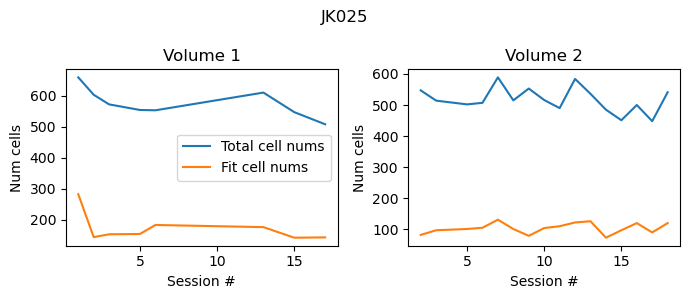

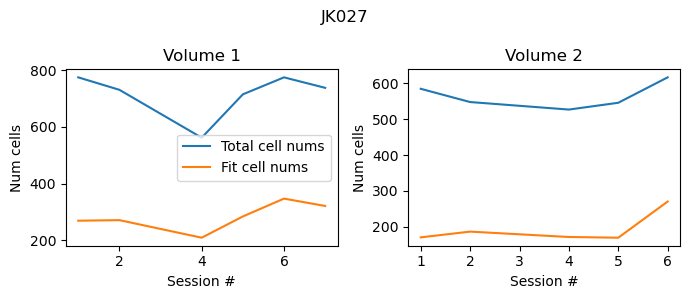

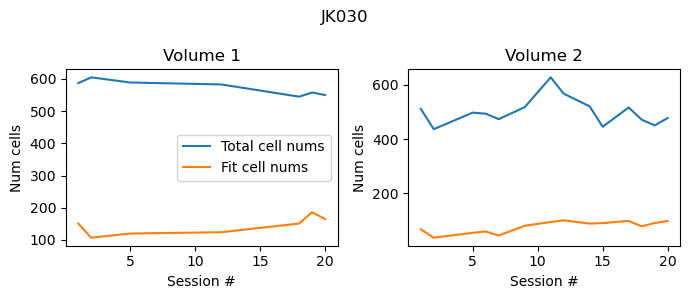

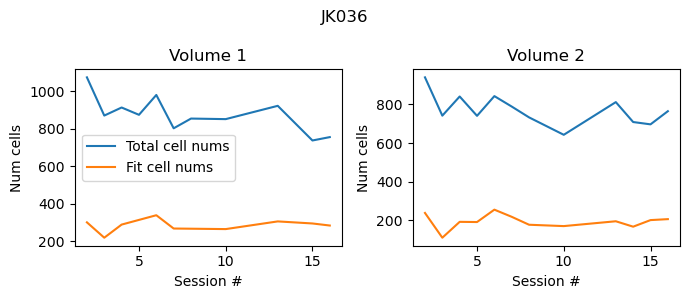

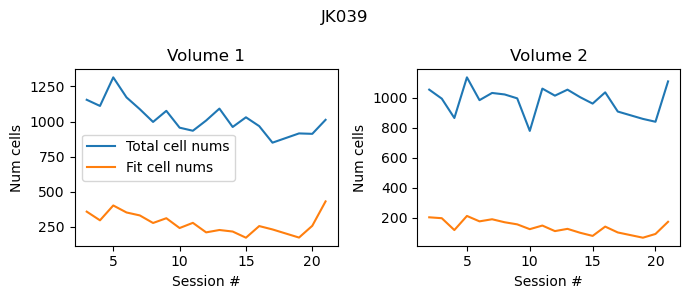

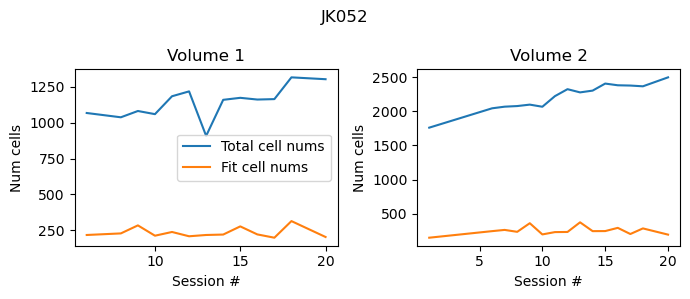

In [14]:
for mouse in mice:
    fig, ax = plt.subplots(1,2, figsize=(7,3))
    for volume in range(1,3):
        sessions, total_cell_nums, fit_cell_nums = get_volume_cell_nums(mouse, volume, training_volume_df, pop_res_dir)
        ax[volume-1].plot(sessions, total_cell_nums, label='Total cell nums')
        ax[volume-1].plot(sessions, fit_cell_nums, label='Fit cell nums')
        ax[volume-1].set_xlabel('Session #')
        ax[volume-1].set_ylabel('Num cells')
        ax[volume-1].set_title(f'Volume {volume}')
    ax[0].legend()
    fig.suptitle(f'JK{mouse:03}')
    fig.tight_layout()

In [4]:
pop_res_dir = results_dir / 'pop_responses' / 'touch_before_answer'

num_fitcells_volume = np.zeros((len(mice), 2))
for mouse in mice:
    for volume in range(1,3):
        sessions, total_cell_nums, fit_cell_nums = get_volume_cell_nums(mouse, volume, training_volume_df, pop_res_dir)
        num_fitcells_volume[mice.index(mouse), volume-1] = np.mean(fit_cell_nums)

In [6]:
print(np.mean(num_fitcells_volume))
print(np.std(num_fitcells_volume))

196.51129793695586
67.95412393501688


# Number of touch neurons
- Roughly defined by those that have variance explained reduced by 0.05
    - From ridge for now. It takes a lot of time to run lasso
- Compare this with p-value-based touch neurons
    - Before answer, after answer, combined
    

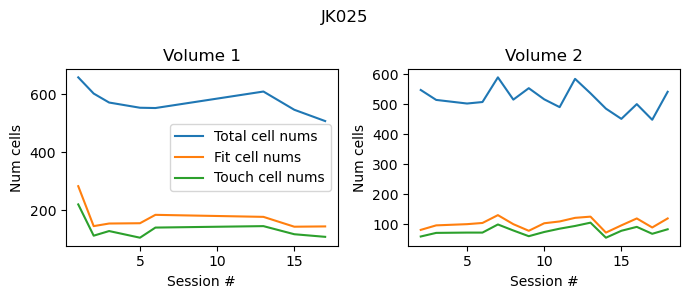

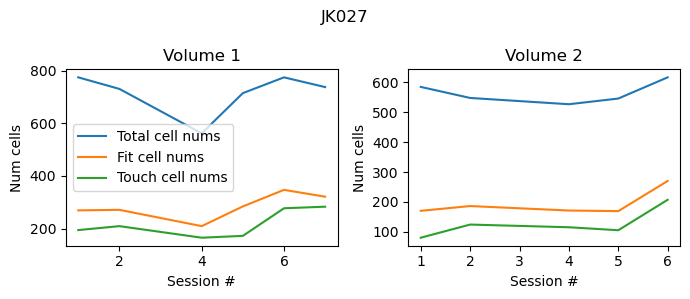

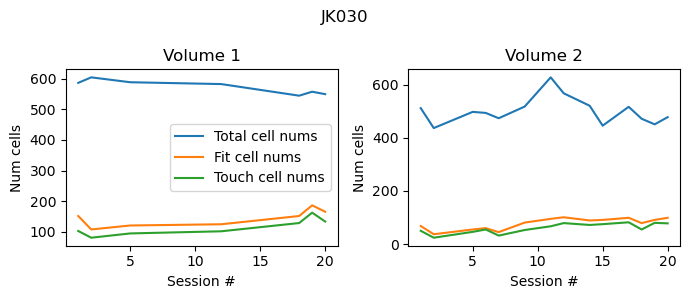

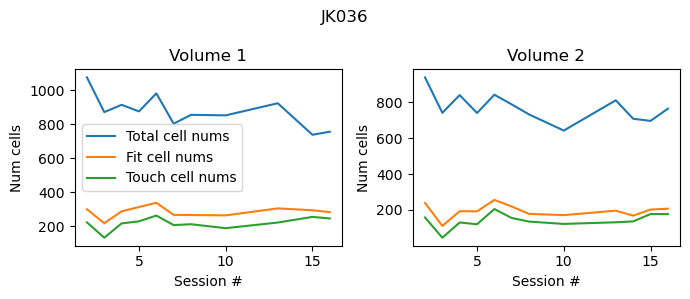

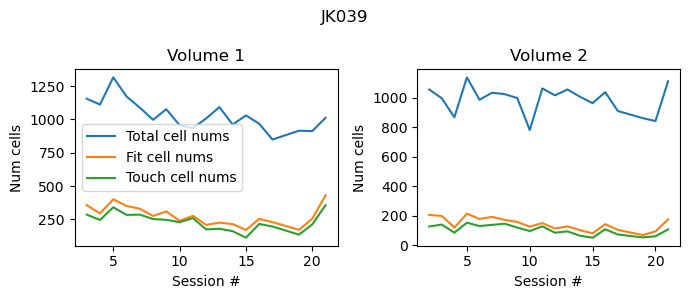

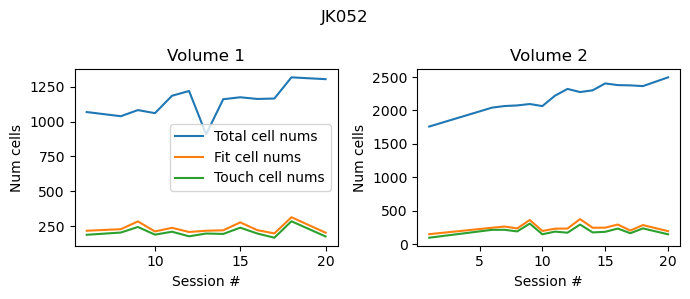

In [28]:
glm_dir = Path(r'C:\JK\results\neuron_glm\ridge\touch_combined')
touch_threshold = 0.05
fit_threshold = 0.05

num_cell_df = pd.DataFrame(columns=['mouse', 'volume', 'session', 'num_cells', 'num_fit_cells', 'num_touch_cells'])
for mouse in mice:
    fig, ax = plt.subplots(1,2, figsize=(7,3))
    for axi in range(2):
        volume = axi + 1
        planes = range(1,5) if volume==1 else range(5,9)
        sessions = [int(s) for s in training_volume_df.query("mouse==@mouse and volume==@volume").session]

        num_touch_cell_sessions = []
        num_fit_cell_sessions = []
        num_cell_sessions = []
        for session in sessions:
            num_touch_cell = 0
            num_fit_cell = 0
            num_cell = 0
            for plane in planes:
                glm_fn = glm_dir / f'JK{mouse:03}S{session:02}_plane{plane}_glm_result.nc'
                with xr.open_dataset(glm_fn) as glm_result:
                    glm_result.load()
                    num_touch_cell += sum(glm_result.varexp_drop.sel(dropped_feature='touch') >= touch_threshold)
                    num_fit_cell += sum(glm_result.varexp_model_final >= fit_threshold)
                    num_cell += glm_result.cell_id.size

            num_touch_cell_sessions.append(num_touch_cell)
            num_fit_cell_sessions.append(num_fit_cell)
            num_cell_sessions.append(num_cell)
        num_cell_df = num_cell_df.append(pd.DataFrame({'mouse':mouse, 'volume':volume, 'session':sessions, 
                                                       'num_cells':num_cell_sessions, 'num_fit_cells':num_fit_cell_sessions, 'num_touch_cells':num_touch_cell_sessions}))
        ax[axi].plot(sessions, num_cell_sessions, label='Total cell nums')
        ax[axi].plot(sessions, num_fit_cell_sessions, label='Fit cell nums')
        ax[axi].plot(sessions, num_touch_cell_sessions, label='Touch cell nums')
        ax[axi].set_xlabel('Session #')
        ax[axi].set_ylabel('Num cells')
        ax[axi].set_title(f'Volume {volume}')
    ax[0].legend()
    fig.suptitle(f'JK{mouse:03}')
    fig.tight_layout()
        

In [29]:
num_cell_df.to_pickle(glm_dir / 'num_cells_stats.pkl')


In [33]:
print(num_cell_df.num_touch_cells.mean())
print(num_cell_df.num_touch_cells.std())

151.0
72.25024499680192


# Variance explained

# Look at one example

In [ ]:
mouse = 25
volume = 2
comp_sessions = [5,6,7]

